In [1]:
# Imports 
import os
import sys
import gc
from pathlib import Path
import time
import yaml
import h5py
import asdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

config = yaml.safe_load(open('config_c000_small.yaml', 'r'))

sim_dir = Path(config['sim_params']['sim_dir'])
simname = config['sim_params']['sim_name']
z = config['sim_params']['z_mock']

subsample_dir = Path(config['sim_params']['subsample_dir'])

want_ranks = config['HOD_params']['want_ranks']
newseed = 600

## Completeness check

The `prepare_sim.py` script should only return files for a slab if the slab was correctly generated. This is a check to see if all the slabs have their files generated.

In [2]:
numslabs = 1 # Number of expected slabs per cosmology

phase_list = np.load('AbacusSmall_phases.npy')
phase_list = phase_list.astype(int)
expected_slab_number = [numslabs for i in range(len(phase_list))] # 34 slabs per cosmology ?

actual_slab_number = []
for i in range(len(phase_list)):
    savedir = str(subsample_dir / f'AbacusSummit_small_c000_ph{phase_list[i]:03d}/z{z:.3f}/')
    
    missing_slabs_number = 0
    if not os.path.isdir(savedir):
        actual_slab_number.append(0)
        continue
    
    for i in range(numslabs):
        outfilename_halos = savedir + '/halos_xcom_'+str(i)+'_seed'+str(newseed)+'_abacushod_oldfenv_new.h5'
        outfilename_particles = savedir + '/particles_xcom_'+str(i)+'_seed'+str(newseed)+'_abacushod_oldfenv_new.h5'
        if want_ranks:
            outfilename_particles = savedir+'/particles_xcom_'+str(i)+'_seed'+str(newseed)+'_abacushod_oldfenv_withranks_new.h5'
        if not os.path.exists(outfilename_halos) or not os.path.exists(outfilename_particles):
            missing_slabs_number += 1

    actual_slab_number.append(numslabs - missing_slabs_number)
    
df = pd.DataFrame({'Phase': phase_list, 'Expected': expected_slab_number, 'Actual': actual_slab_number})

# Make df pretty
def color_cell_complete(val):
    if val == numslabs:
        color = '#006400'
    elif val == 0:
        color = '#8B0000'
    else:
        color = '#B8860B'
    return color

def row_cell_color(row):
    return [f"background-color: {color_cell_complete(val)}" for val in row]

def row_cell_bold(row, col=None):
    if col:
        return [f"font-weight: bold;" for val in row if val=='Phase']
    return [f"font-weight: bold;" for val in row]

def make_pretty(styler):
    styler.set_caption("Simulation completeness")
    styler.apply(row_cell_color, axis=1, subset=pd.IndexSlice[['Actual'],:])
    
    # Make first line as header when transposed
    styler.hide(axis=1) # hide columns numbers
    styler.apply(row_cell_bold, axis=1, subset=pd.IndexSlice[['Phase'],:]) # bold first line
    styler.apply_index(row_cell_bold, axis='index', col=True) # bold first column
    
    return styler

df.T.style.pipe(make_pretty)

## Halo mass histogram

All halo mass functions should roughly have the same shape. We plot them to check if they are similar.
??
> Note : we have to plot them 100 by 100 because of the size of the files, which is too big to store all cosmologies in memory at once.  

In [3]:
# Import references

save_path = '/pscratch/sd/s/sbouchar/00- Archives/Halo_mass_function/'

masses_full = np.load(save_path + f'masses_full_z{z:.3f}.npy')
masses_LRG = np.load(save_path + f'masses_LRG_z{z:.3f}.npy')
masses_BGS = np.load(save_path + f'masses_BGS.npy')
masses_alex_box = np.load(save_path + f'masses_alex_box_z{z:.3f}.npy')

In [5]:
# Load the halos only
halo_masses = []

folder_list = list(subsample_dir.glob('AbacusSummit_small_*'))#[80:85]
folder_list.sort()

for folder in folder_list:
    start = time.time()
    simname = folder.name
    # print(simname)

    # Particle mass for this cosmo
    halo_info_dir = sim_dir / simname / 'halos' / f'z{z:4.3f}' / 'halo_info'
    halo_info_fns = list( halo_info_dir.glob('*.asdf') )

    f = asdf.open(halo_info_fns[0], lazy_load=True, copy_arrays=False)
    header = f['header']

    params = {}
    params['Mpart'] = header['ParticleMassHMsun']

    # From AbacusHOD : Halo masses
    cosmo_dir = subsample_dir / simname / f'z{z:.3f}' 
    numslabs = len(list(cosmo_dir.glob('halos_xcom_*.h5'))) # Number of slabs for this cosmo (/!\ Changed from before)
    if numslabs == 0:
        print(f'Warning : No slabs found for cosmo {simname} !')
        continue
    elif numslabs != 1:
        print(f'Warning : Missing slabs ({numslabs}) to cosmo {simname} !')
        continue
        
    tmp_halo_masses = [] # Store the halo masses of the slabs
    for slab in range(numslabs):
        halofilename = cosmo_dir / f'halos_xcom_{slab}_seed600_abacushod_oldfenv' 
        halofilename = str(halofilename) + '_new.h5'
        newfile = h5py.File(halofilename, 'r')
        maskedhalos = newfile['halos']

        halo_mass = maskedhalos['N'] * params['Mpart']
        tmp_halo_masses.append(halo_mass)

    halo_masses.append(np.concatenate(tmp_halo_masses)) # Concatenate the halo masses in one array
    
    # cleanup to free memory
    del f
    del header
    del params
    del tmp_halo_masses
    del newfile
    del maskedhalos
    del halo_mass
    gc.collect()
    
    end = time.time()
    print(f'Time ({simname}) : {end-start:.2f}s', end='\r')

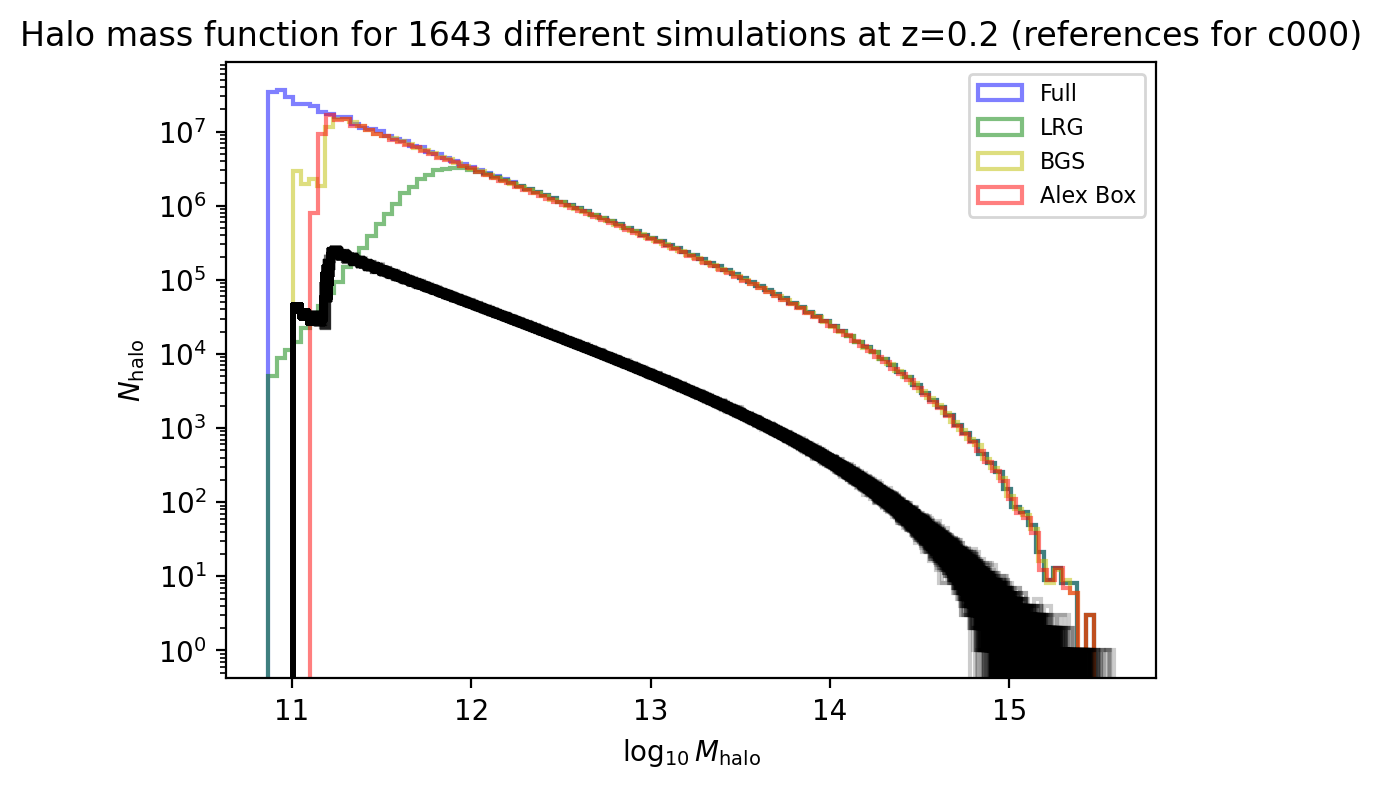

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot references
ax.hist(np.log10(masses_full), bins=100, histtype='step', color='b', lw=1.5, alpha=0.5, label='Full')
ax.hist(np.log10(masses_LRG), bins=100, histtype='step', color='g', lw=1.5, alpha=0.5, label='LRG')
ax.hist(np.log10(masses_BGS), bins=100, histtype='step', color='y', lw=1.5, alpha=0.5, label='BGS')
ax.hist(np.log10(masses_alex_box), bins=100, histtype='step', color='r', lw=1.5, alpha=0.5, label='Alex Box')

for halo_mass in halo_masses:
    ax.hist(np.log10(halo_mass), bins=100, histtype='step', color='k', lw=1.5, alpha=0.2)

ax.set_yscale('log')
ax.legend(fontsize=8, loc='upper right')
ax.set_title(f'Halo mass function for {len(halo_masses)} different simulations at z=0.2 (references for c000)')
ax.set_xlabel(r'$\log_{10} M_{\rm halo}$')
ax.set_ylabel(r'$N_{\rm halo}$');

## Corruption check

Check if the files are corrupted by opening them. If h5py raises an error, the file is corrupte and should be computed again.

In [7]:
# Check we can open every file !!
sim_dir = '/global/cfs/cdirs/desi/cosmosim/Abacus/small/'
subsample_dir_base = '/pscratch/sd/s/sbouchar/abacus_subsamples_small/'
z_mock = 0.2

phase_list = np.load('AbacusSmall_phases.npy')
phase_list = phase_list.astype(int)

for phase in phase_list:

    sim_name = f'AbacusSummit_small_c000_ph{phase:03d}'

    simname = Path(sim_name)
    sim_dir = Path(sim_dir)

    # create mock_dir if not created
    subsample_dir = \
        Path(subsample_dir_base) / simname / ('z%4.3f'%z_mock)


    halo_info_fns = \
                    list((sim_dir / simname / 'halos' / ('z%4.3f'%z_mock) / 'halo_info').glob('*.asdf'))
    f = asdf.open(halo_info_fns[0], lazy_load=True, copy_arrays=False)
    header = f['header']

    # settitng up chunking
    chunk = 0
    n_chunks = 1
    n_jump = int(np.ceil(len(halo_info_fns)/n_chunks))
    start = ((chunk)*n_jump)
    end = ((chunk+1)*n_jump)
    if end > len(halo_info_fns):
        end = len(halo_info_fns)
    lbox = header['BoxSize']

    for eslab in range(start, end):
        halofilename = subsample_dir / ('halos_xcom_%d_seed600_abacushod_oldfenv'%eslab)
        particlefilename = subsample_dir / ('particles_xcom_%d_seed600_abacushod_oldfenv'%eslab)

        particlefilename = str(particlefilename) + '_withranks'
        halofilename = str(halofilename) + '_new.h5'
        particlefilename = str(particlefilename) + '_new.h5'
        
        try : 
            newfile = h5py.File(halofilename, 'r')
        except:
            print(f'Error with {halofilename} in {simname} !')
            continue
        try:
            newpart = h5py.File(particlefilename, 'r')
        except:
            print(f'Error with {particlefilename} in {simname} !')
            continue